In [68]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
# read in the data
df = pd.read_csv("./../data/supervised_1_1.csv")

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
df.set_index('date', inplace=True)
print(df.shape)
df.head()

(7316300, 21)


,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,...,rotterdam,brent,wti,eurusd,vehicles,state,station,global_mean,state_mean,num_days
date,,,,,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,15211.0,10,0,1.546131,1.561237,0
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622486,109.699997,101.669998,1.369580,9146.0,10,0,1.560708,1.578196,1
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622136,109.699997,101.669998,1.369580,9843.0,10,0,1.564237,1.581731,2
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.621785,109.838928,102.008537,1.370161,13502.0,10,0,1.563935,1.581525,3
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.620475,109.522926,102.058907,1.368282,12876.0,10,0,1.566228,1.582620,4


In [5]:
# try removing the averages so as to not include endogenous variables on the rigth hand side
df.drop(['global_mean', 'state_mean', 'eurusd', 'vehicles'], axis=1, inplace=True)
print(df.shape)
df.head()

(7316300, 17)


,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,total,rotterdam,brent,wti,state,station,num_days
date,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622837,109.424042,101.258553,10,0,0
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622486,109.699997,101.669998,10,0,1
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622136,109.699997,101.669998,10,0,2
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.621785,109.838928,102.008537,10,0,3
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.620475,109.522926,102.058907,10,0,4


In [6]:
rot = df['rotterdam'][:575]
brent = df['brent'][:575]
wti = df['wti'][:575]

ARIMA for rot

In [45]:
rot_train = rot[:-31]
rot_test = rot[-31:]

In [93]:
p = 15
q = 2
d = 0
model = ARIMA(rot_train, order=(p, q, d))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:           D2.rotterdam   No. Observations:                  542
Model:                ARIMA(15, 2, 0)   Log Likelihood                1832.524
Method:                       css-mle   S.D. of innovations              0.008
Date:                Thu, 05 Apr 2018   AIC                          -3631.048
Time:                        12:23:17   BIC                          -3558.028
Sample:                    05-18-2014   HQIC                         -3602.495
                         - 11-10-2015                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                5.988e-06   4.29e-05      0.140      0.889   -7.81e-05    9.01e-05
ar.L1.D2.rotterdam     -0.9211      0.043    -21.499      0.000      -1.005      -0.837
ar.L2.D2.rotterd

In [94]:
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=31)[0]
for index, day in enumerate(forecast):
    print('Forecast: %f' % day, ': Day', index)

Forecast: 0.414074 : Day 0
Forecast: 0.417596 : Day 1
Forecast: 0.420807 : Day 2
Forecast: 0.424292 : Day 3
Forecast: 0.427922 : Day 4
Forecast: 0.432267 : Day 5
Forecast: 0.435038 : Day 6
Forecast: 0.438151 : Day 7
Forecast: 0.441879 : Day 8
Forecast: 0.445548 : Day 9
Forecast: 0.449290 : Day 10
Forecast: 0.453078 : Day 11
Forecast: 0.457723 : Day 12
Forecast: 0.461745 : Day 13
Forecast: 0.465839 : Day 14
Forecast: 0.470058 : Day 15
Forecast: 0.473940 : Day 16
Forecast: 0.477733 : Day 17
Forecast: 0.481627 : Day 18
Forecast: 0.485444 : Day 19
Forecast: 0.489302 : Day 20
Forecast: 0.493248 : Day 21
Forecast: 0.497092 : Day 22
Forecast: 0.500982 : Day 23
Forecast: 0.504954 : Day 24
Forecast: 0.508981 : Day 25
Forecast: 0.512965 : Day 26
Forecast: 0.516993 : Day 27
Forecast: 0.521056 : Day 28
Forecast: 0.525049 : Day 29
Forecast: 0.529046 : Day 30


/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [95]:
rot_test

date
2015-11-11    0.422269
2015-11-12    0.364591
2015-11-13    0.353165
2015-11-14    0.348899
2015-11-15    0.344634
2015-11-16    0.340368
2015-11-17    0.353718
2015-11-18    0.353937
2015-11-19    0.359760
2015-11-20    0.361069
2015-11-21    0.360033
2015-11-22    0.358996
2015-11-23    0.357959
2015-11-24    0.382379
2015-11-25    0.378281
2015-11-26    0.382307
2015-11-27    0.385947
2015-11-28    0.384212
2015-11-29    0.382478
2015-11-30    0.380743
2015-12-01    0.376809
2015-12-02    0.365558
2015-12-03    0.353431
2015-12-04    0.343880
2015-12-05    0.340438
2015-12-06    0.336996
2015-12-07    0.333554
2015-12-08    0.331715
2015-12-09    0.331795
2015-12-10    0.331913
2015-12-11    0.332031
Name: rotterdam, dtype: float64

In [96]:
sqrt(mean_squared_error(forecast, rot_test))

0.12064324562131275

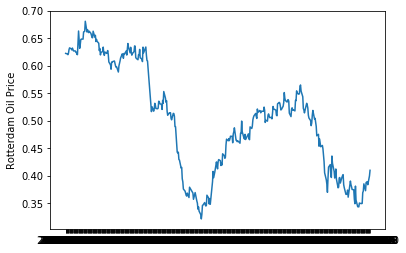

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(rot[:-31])
plt.ylabel('Rotterdam Oil Price')
plt.show()

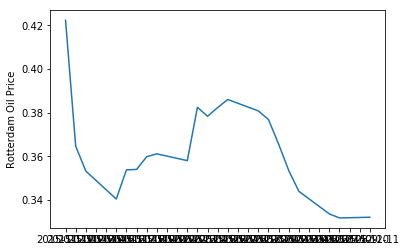

In [61]:
plt.plot(rot[-31:])
plt.ylabel('Rotterdam Oil Price')
plt.show()

In [64]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [65]:
lag_acf = acf(rot, nlags=31)
lag_pacf = pacf(rot, nlags=31, method='ols')

Text(0.5,1,'Autocorrelation Function')

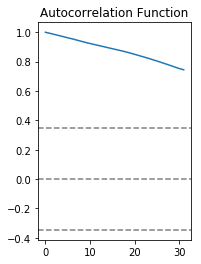

In [70]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(lag_acf)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

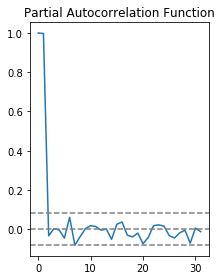

In [71]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(rot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(rot)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()